In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn fuzzy-c-means tensorflow shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd

file_path = '/content/drive/My Drive/Dataset/UNSW_NB15_training-set.csv'  # Adjust the path
df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# 🔹 Strip whitespace & convert column names to lowercase
df.columns = df.columns.str.strip().str.lower()

# 🔹 Define selected features (ensure lowercase)
features = [
    'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes',
    'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt',
    'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt',
    'synack', 'ackdat', 'smean', 'dmean', 'ct_srv_src', 'ct_state_ttl',
    'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
    'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst',
    'is_sm_ips_ports'
]

# 🔹 Find available features in the dataset
available_features = [col for col in features if col in df.columns]

# 🔹 Ensure 'label' column exists
if 'label' not in df.columns:
    raise KeyError("❌ 'label' column is missing from the dataset!")

# 🔹 Select available features + label column
df = df[available_features + ['label']].copy()

# 🔹 Encode categorical columns
for col in ['proto', 'service', 'state']:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col])

# 🔹 Encode labels (Normal = 0, Attack = 1)
df['label'] = df['label'].astype(int)

# 🔹 Normalize numeric features
scaler = StandardScaler()
df[available_features] = scaler.fit_transform(df[available_features])

# 🔹 Convert to NumPy arrays
X = df[available_features].values
y = df['label'].values

# 🔹 Ensure dataset has both classes
if len(np.unique(y)) < 2:
    raise ValueError("❌ Dataset has only one class. Check preprocessing!")

# 🔹 Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 🔹 Balance dataset using undersampling (if needed)
if len(np.unique(y_train)) > 1:
    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)

# 🔹 Print class distribution after processing
train_class_dist = pd.Series(y_train).value_counts().to_dict()
test_class_dist = pd.Series(y_test).value_counts().to_dict()

print(f"Class Distribution After Processing (Train Set): {train_class_dist}")
print(f"Class Distribution After Processing (Test Set): {test_class_dist}")
print(f"Data Preprocessing Done! Final Shape: {X.shape}")

Class Distribution After Processing (Train Set): {0: 44800, 1: 44800}
Class Distribution After Processing (Test Set): {1: 23869, 0: 11200}
Data Preprocessing Done! Final Shape: (175341, 40)


In [ ]:
# Apply Fuzzy C-Means Clustering for Anomaly Detection

from fcmeans import FCM
import pandas as pd

# 🔹 Apply Fuzzy C-Means
fcm = FCM(n_clusters=2, max_iter=150, m=2.0)
fcm.fit(X)  # Use the processed feature matrix

# 🔹 Assign cluster labels
cluster_labels = fcm.predict(X)

# 🔹 Reconstruct DataFrame for analysis
df_clustered = pd.DataFrame(X, columns=available_features)  # Recreate df with features
df_clustered['Cluster'] = cluster_labels
df_clustered['Label'] = y  # Add ground truth labels back

# 🔹 Map clusters to normal/anomalous traffic
df_clustered['Anomaly'] = (
    df_clustered['Cluster'] == df_clustered.groupby('Label')['Cluster'].transform(lambda x: x.mode()[0])
).astype(int)

print("FCM Clustering Done!")

FCM Clustering Done!


In [ ]:
# Train Optimized Deep ANN (DANN) with Batch Normalization, Dropout, and AdamW Optimizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 🔹 Define Optimized Deep ANN Model
model_dann = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# 🔹 Compile Model with AdamW Optimizer
model_dann.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# 🔹 Implement Early Stopping to Prevent Overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 🔹 Train Model
history_dann = model_dann.fit(X_train, y_train, epochs=50, batch_size=64,
                              validation_data=(X_test, y_test),
                              callbacks=[early_stopping])

# 🔹 Make Predictions
y_pred_dann = (model_dann.predict(X_test) > 0.5).astype("int32")

# 🔹 Train & Evaluate SVM Model
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# 🔹 Compute Accuracy Scores
ann_acc = accuracy_score(y_test, y_pred_dann)
svm_acc = accuracy_score(y_test, y_pred_svm)

# 🔹 Print Model Performance
print(f"ANN Accuracy: {ann_acc:.4f}")
print(f"SVM Accuracy: {svm_acc:.4f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1400/1400 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8793 - loss: 0.2545 - val_accuracy: 0.9229 - val_loss: 0.1488
Epoch 2/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9192 - loss: 0.1623 - val_accuracy: 0.9309 - val_loss: 0.1325
Epoch 3/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9262 - loss: 0.1508 - val_accuracy: 0.9236 - val_loss: 0.1397
Epoch 4/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9250 - loss: 0.1479 - val_accuracy: 0.9242 - val_loss: 0.1386
Epoch 5/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9259 - loss: 0.1472 - val_accuracy: 0.9292 - val_loss: 0.1316
Epoch 6/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9288 - loss: 0.1429 - val_accuracy: 0.9238 - val_loss: 0.1415
Epoch 7/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9302 - loss: 0.1404 - val_accuracy: 0.9340 - val_loss: 0.1266
Epoch 8/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9308 - loss: 0.1401 - val_acc

PermutationExplainer explainer: 101it [00:14,  1.95it/s]
<ipython-input-13-ecb2e333f1ff>:57: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test[:100], feature_names=available_features)


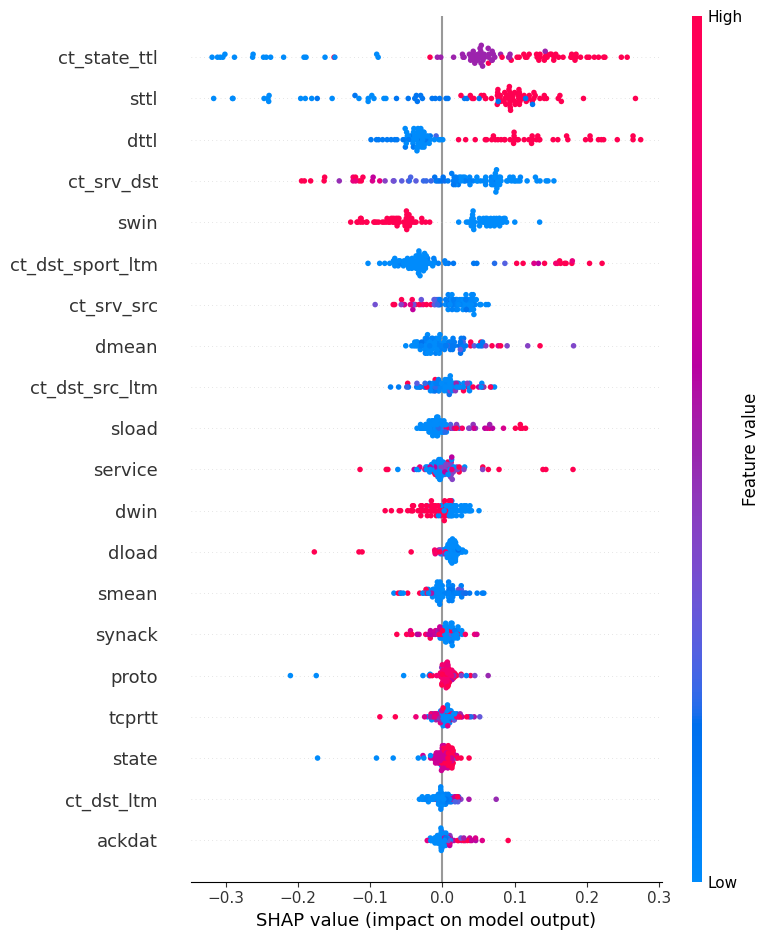


**SHAP Analysis Summary:**
The following features significantly impact anomaly detection:

**Features that Increase Anomaly Likelihood:**
- `ct_state_ttl` (Count of State Transitions) → SHAP importance: 0.1285
- `sttl` (Source TTL) → SHAP importance: 0.1060
- `dttl` (Destination TTL) → SHAP importance: 0.0780
- `ct_srv_dst` (Count of Service Connections) → SHAP importance: 0.0703
- `ct_srv_src` (Count of Connections from Source) → SHAP importance: 0.0292
- `dmean` (Destination Mean Packet Size) → SHAP importance: 0.0272
- `ct_dst_src_ltm` (Count of Source-Destination Connections) → SHAP importance: 0.0213
- `sload` (Source Load) → SHAP importance: 0.0212
- `service` (Service Type) → SHAP importance: 0.0206
- `dload` (Destination Load) → SHAP importance: 0.0166
- `synack` (SYN-ACK Time) → SHAP importance: 0.0142
- `proto` (Protocol Type) → SHAP importance: 0.0135
- `tcprtt` (TCP Round Trip Time) → SHAP importance: 0.0125
- `ct_dst_ltm` (Count of Connections to Destination) → SHAP impor

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Define feature name mapping (Example: Add full names for each feature)
feature_full_names = {
    "dur": "Duration",
    "proto": "Protocol Type",
    "service": "Service Type",
    "state": "Connection State",
    "spkts": "Source Packets",
    "dpkts": "Destination Packets",
    "sbytes": "Source Bytes",
    "dbytes": "Destination Bytes",
    "rate": "Packet Rate",
    "sttl": "Source TTL",
    "dttl": "Destination TTL",
    "sload": "Source Load",
    "dload": "Destination Load",
    "sloss": "Source Loss",
    "dloss": "Destination Loss",
    "sinpkt": "Source Inter-Packet Time",
    "dinpkt": "Destination Inter-Packet Time",
    "sjit": "Source Jitter",
    "djit": "Destination Jitter",
    "swin": "Source TCP Window",
    "stcpb": "Source TCP Base Sequence",
    "dtcpb": "Destination TCP Base Sequence",
    "dwin": "Destination TCP Window",
    "tcprtt": "TCP Round Trip Time",
    "synack": "SYN-ACK Time",
    "ackdat": "ACK Data",
    "smean": "Source Mean Packet Size",
    "dmean": "Destination Mean Packet Size",
    "ct_srv_src": "Count of Connections from Source",
    "ct_state_ttl": "Count of State Transitions",
    "ct_dst_ltm": "Count of Connections to Destination",
    "ct_src_dport_ltm": "Count of Source Port Connections",
    "ct_dst_sport_ltm": "Count of Destination Port Connections",
    "ct_dst_src_ltm": "Count of Source-Destination Connections",
    "is_ftp_login": "FTP Login Attempt",
    "ct_ftp_cmd": "FTP Command Count",
    "ct_flw_http_mthd": "HTTP Method Count",
    "ct_src_ltm": "Count of Source Connections",
    "ct_srv_dst": "Count of Service Connections",
    "is_sm_ips_ports": "Same IP Source-Destination Ports"
}

# 🔹 Initialize SHAP explainer
explainer = shap.Explainer(model_dann, X_train)

# 🔹 Compute SHAP values on a sample of the test set
shap_values = explainer(X_test[:100])

# 🔹 Generate SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test[:100], feature_names=available_features)

# 🔹 Compute mean absolute SHAP values to rank feature importance
shap_importance = np.abs(shap_values.values).mean(axis=0)
sorted_indices = np.argsort(shap_importance)[::-1]  # Sort in descending order

# Separate features based on impact direction
increase_impact = []
decrease_impact = []

for idx in sorted_indices:
    mean_shap = shap_values.values[:, idx].mean()
    impact = "increase" if mean_shap > 0 else "decrease"

    feature_short = available_features[idx]
    feature_full = feature_full_names.get(feature_short, feature_short)  # Get full name, fallback to short if missing
    feature_tuple = (feature_short, feature_full, shap_importance[idx])

    if impact == "increase":
        increase_impact.append(feature_tuple)
    else:
        decrease_impact.append(feature_tuple)

# 🔹 Generate English explanation
explanation = f"\n**SHAP Analysis Summary:**\n"
explanation += "The following features significantly impact anomaly detection:\n\n"

# Features that increase the likelihood of an anomaly
explanation += "**Features that Increase Anomaly Likelihood:**\n"
for feature_short, feature_full, importance in increase_impact:
    explanation += f"- `{feature_short}` ({feature_full}) → SHAP importance: {importance:.4f}\n"

# Features that decrease the likelihood of an anomaly
explanation += "\n **Features that Decrease Anomaly Likelihood:** \n"
for feature_short, feature_full, importance in decrease_impact:
    explanation += f"- `{feature_short}` ({feature_full}) → SHAP importance: {importance:.4f}\n"

explanation += "\nThese insights help in understanding which features contribute most to detecting anomalies."

print(explanation)

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

**Model Comparison: DANN vs. SVM**
Metric                        DANN           SVM            
------------------------------------------------------------
Accuracy                      0.9410         0.9369
Precision                     0.9674         0.9563
Recall/ TruePositiveRate(TPR) 0.9452         0.9507
False Positive Rate (FPR)     0.0679         0.0926


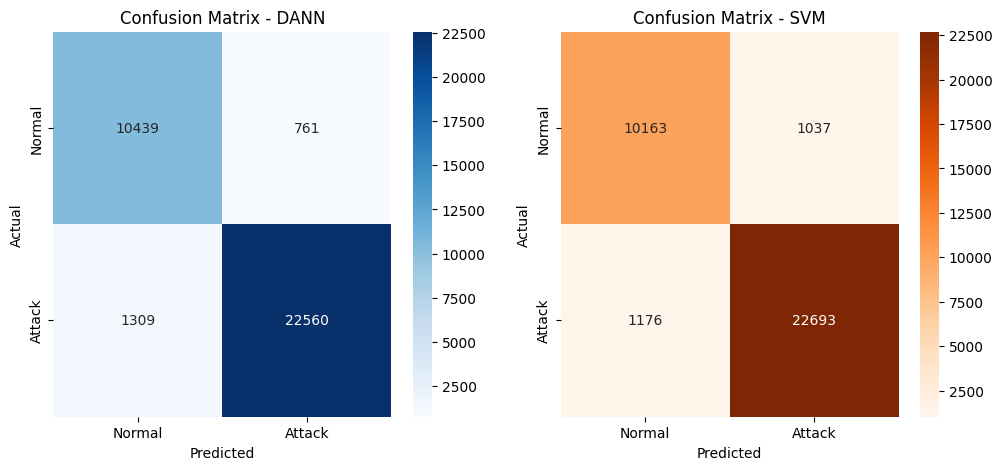

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# 🔹 Predictions for DANN
y_pred_dann = (model_dann.predict(X_test) > 0.5).astype("int32")

# 🔹 Compute Metrics for DANN
dann_acc = accuracy_score(y_test, y_pred_dann)
dann_recall = recall_score(y_test, y_pred_dann)
dann_precision = precision_score(y_test, y_pred_dann)

# 🔹 Compute Confusion Matrix for DANN
conf_matrix_dann = confusion_matrix(y_test, y_pred_dann)
TN_dann, FP_dann, FN_dann, TP_dann = conf_matrix_dann.ravel()

# 🔹 Compute Additional Metrics for DANN
dann_fpr = FP_dann / (FP_dann + TN_dann)  # False Positive Rate (FPR)
dann_detection_rate = TP_dann / (TP_dann + FN_dann)  # True Positive Rate (Detection Rate)

# 🔹 Predictions for SVM Model
y_pred_svm = svm_model.predict(X_test)

# 🔹 Compute Metrics for SVM
svm_acc = accuracy_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)

# 🔹 Compute Confusion Matrix for SVM
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
TN_svm, FP_svm, FN_svm, TP_svm = conf_matrix_svm.ravel()

# 🔹 Compute Additional Metrics for SVM
svm_fpr = FP_svm / (FP_svm + TN_svm)  # False Positive Rate (FPR)
svm_detection_rate = TP_svm / (TP_svm + FN_svm)  # True Positive Rate (Detection Rate)

# 🔹 Print Comparison Table
print("\n**Model Comparison: DANN vs. SVM**")
print(f"{'Metric':<30}{'DANN':<15}{'SVM':<15}")
print("-" * 60)
print(f"{'Accuracy':<30}{dann_acc:.4f}{svm_acc:>15.4f}")
print(f"{'Precision':<30}{dann_precision:.4f}{svm_precision:>15.4f}")
print(f"{'Recall/ TruePositiveRate(TPR)':<30}{dann_recall:.4f}{svm_recall:>15.4f}")
print(f"{'False Positive Rate (FPR)':<30}{dann_fpr:.4f}{svm_fpr:>15.4f}")

# 🔹 Plot Confusion Matrix for DANN
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_dann, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - DANN")

# 🔹 Plot Confusion Matrix for SVM
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Oranges", xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")

plt.show()